# Assignment 2

### Name: Yelisetty

### Roll Number: 21CS30036


## Importing Libraries


In [2]:
# Base libraries
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale

# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Target Data


### Loading dataset


In [3]:
cancer_targets = pd.read_csv("./data/Copy of actual.csv")

In [4]:
cancer_targets.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [5]:
cancer_targets.dtypes

patient     int64
cancer     object
dtype: object

### Class distribution


In [6]:
print(cancer_targets["cancer"].value_counts())
print()
print("Number of samples;", cancer_targets.shape)

cancer
ALL    47
AML    25
Name: count, dtype: int64

Number of samples; (72, 2)


Text(0.5, 1.0, 'Class Distributions \n ( AML ||  ALL)')

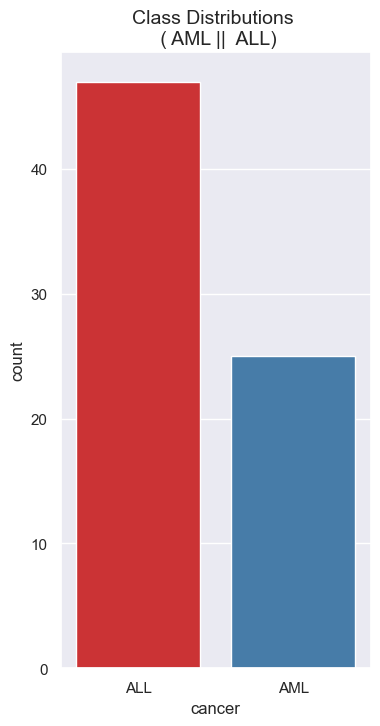

In [7]:
plt.figure(figsize=(4, 8))
colors = ["AML", "ALL"]
sns.countplot(data=cancer_targets, x='cancer', palette="Set1")
plt.title('Class Distributions \n ( AML ||  ALL)', fontsize=14)

## Train and test dataset


In [8]:
cancer_train = pd.read_csv("./data/data_train.csv")
cancer_test = pd.read_csv("./data/data_test.csv")

print("Train shape:", cancer_train.shape)
print("Test shape:", cancer_test.shape)

cancer_train.head(4)

Train shape: (7129, 78)
Test shape: (7129, 70)


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A


### Preprocessing


We will be combining the train and test dataset for preprocessing and then we will split them again.


In [9]:
def rename_columns(df):
    for col in df.columns:
        if "call" in col:
            loc = df.columns.get_loc(col)
            patient = df.columns[loc-1]
            df.rename(columns={col: f'Call_{patient}'}, inplace=True)

In [10]:
rename_columns(df=cancer_train)
rename_columns(df=cancer_test)

cancer_train["Gene"] = cancer_train["Gene Description"] + \
    '_' + cancer_train["Gene Accession Number"]
cancer_test["Gene"] = cancer_test["Gene Description"] + \
    '_' + cancer_test["Gene Accession Number"]

cancer_train = cancer_train.T
cancer_train.columns = cancer_train.iloc[-1]
cancer_train = cancer_train[2:-1]
cancer_train['dataset'] = 'train'

cancer_test = cancer_test.T
cancer_test.columns = cancer_test.iloc[-1]
cancer_test = cancer_test[2:-1]
cancer_test['dataset'] = 'test'


df = pd.concat([cancer_train, cancer_test], axis=0, join='inner', sort=False)
df.shape

(144, 7130)

> The columns labeled "Present," "Absent," and "Marginal" represent the detection calls made by the DNA Microarray manufacturer in the paper. These designations are based on comparing p-values of intensity calls to a predefined noise frequency cutoff. Consequently, it is advisable to remove rows where all values are designated as "Absent" (A) calls, as these are deemed unreliable.

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1409797/


### Dropping the columns with all A in calls


In [11]:
call_rows = [row for row in df.index if "Call" in row]
conditional = df.filter(call_rows, axis=0).apply(
    lambda x: x == 'A', axis=1).all()
print(conditional.value_counts())
df = df.loc[:, ~conditional]

False    5328
True     1802
Name: count, dtype: int64


### Removing the call columns


In [12]:
df.drop(call_rows, axis=0, inplace=True)
df['patient'] = df.index
df['patient'] = df['patient'].astype('int')
df.reset_index(drop=True)

Gene,AFFX-BioC-5_at (endogenous control)_AFFX-BioC-5_at,hum_alu_at (miscellaneous control)_hum_alu_at,AFFX-DapX-5_at (endogenous control)_AFFX-DapX-5_at,AFFX-DapX-M_at (endogenous control)_AFFX-DapX-M_at,AFFX-LysX-5_at (endogenous control)_AFFX-LysX-5_at,AFFX-HUMISGF3A/M97935_MA_at (endogenous control)_AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at (endogenous control)_AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at (endogenous control)_AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at (endogenous control)_AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at (endogenous control)_AFFX-HUMRGE/M10098_M_at,...,Transcription factor Stat5b (stat5b) mRNA_U48730_at,Breast epithelial antigen BA46 mRNA_U58516_at,TUBULIN ALPHA-4 CHAIN_X06956_at,PTGER3 Prostaglandin E receptor 3 (subtype EP3) {alternative products}_X83863_at,HMG2 High-mobility group (nonhistone chromosomal) protein 2_Z17240_at,RB1 Retinoblastoma 1 (including osteosarcoma)_L49218_f_at,GB DEF = Glycophorin Sta (type A) exons 3 and 4; partial_M71243_f_at,GB DEF = mRNA (clone 1A7)_Z78285_f_at,dataset,patient
0,88,15091,7,311,21,-13,215,797,14538,9738,...,185,511,389,793,329,36,191,-37,train,1
1,283,11038,37,134,-21,-219,116,433,615,115,...,169,837,442,782,295,11,76,-14,train,2
2,309,16692,183,378,67,104,476,1474,5669,3272,...,315,1199,168,1138,777,41,228,-41,train,3
3,12,15763,45,268,43,-148,155,415,4850,2293,...,240,835,174,627,170,-50,126,-91,train,4
4,168,18128,-28,118,-8,-55,122,483,1284,2731,...,156,649,504,250,314,14,56,-25,train,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,141,22818,2,46,26,-203,25,264,104,-159,...,92,532,239,707,354,-22,260,5,test,65
68,95,39323,-26,73,39,-60,60,306,569,478,...,63,297,358,423,41,0,1777,-49,test,66
69,146,15689,6,302,25,-209,183,657,3762,2164,...,130,639,548,809,445,-2,210,16,test,63
70,431,41570,94,235,27,-626,-249,477,-159,-745,...,84,1141,197,466,349,0,284,-73,test,64


### Combining features and labels


In [13]:
df = pd.merge(left=df, right=cancer_targets,
              left_on='patient', right_on='patient')
print(df.shape)
df.head(5)

(72, 5330)


,AFFX-BioC-5_at (endogenous control)_AFFX-BioC-5_at,hum_alu_at (miscellaneous control)_hum_alu_at,AFFX-DapX-5_at (endogenous control)_AFFX-DapX-5_at,AFFX-DapX-M_at (endogenous control)_AFFX-DapX-M_at,AFFX-LysX-5_at (endogenous control)_AFFX-LysX-5_at,AFFX-HUMISGF3A/M97935_MA_at (endogenous control)_AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at (endogenous control)_AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at (endogenous control)_AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at (endogenous control)_AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at (endogenous control)_AFFX-HUMRGE/M10098_M_at,...,Breast epithelial antigen BA46 mRNA_U58516_at,TUBULIN ALPHA-4 CHAIN_X06956_at,PTGER3 Prostaglandin E receptor 3 (subtype EP3) {alternative products}_X83863_at,HMG2 High-mobility group (nonhistone chromosomal) protein 2_Z17240_at,RB1 Retinoblastoma 1 (including osteosarcoma)_L49218_f_at,GB DEF = Glycophorin Sta (type A) exons 3 and 4; partial_M71243_f_at,GB DEF = mRNA (clone 1A7)_Z78285_f_at,dataset,patient,cancer
0,88,15091,7,311,21,-13,215,797,14538,9738,...,511,389,793,329,36,191,-37,train,1,ALL
1,283,11038,37,134,-21,-219,116,433,615,115,...,837,442,782,295,11,76,-14,train,2,ALL
2,309,16692,183,378,67,104,476,1474,5669,3272,...,1199,168,1138,777,41,228,-41,train,3,ALL
3,12,15763,45,268,43,-148,155,415,4850,2293,...,835,174,627,170,-50,126,-91,train,4,ALL
4,168,18128,-28,118,-8,-55,122,483,1284,2731,...,649,504,250,314,14,56,-25,train,5,ALL


### Separate train and test data


In [14]:
train = df[df['dataset'] == 'train'].iloc[:, 0:-3]
train_target = df[df['dataset'] == 'train'].iloc[:, -1]
test = df[df['dataset'] == 'test'].iloc[:, 0:-3]
test_target = df[df['dataset'] == 'test'].iloc[:, -1]

print(train.shape, train_target.shape)
print(test.shape, test_target.shape)

(38, 5327) (38,)
(34, 5327) (34,)


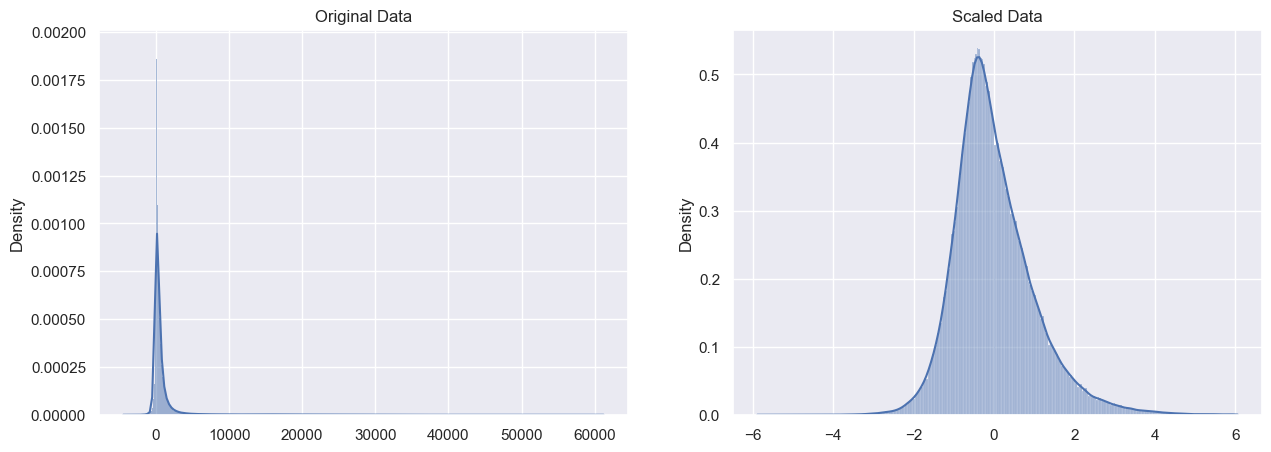

In [15]:
scaler = StandardScaler().fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(np.concatenate(train.values), ax=ax[0], kde=True, stat="density")
sns.histplot(np.concatenate(train_scaled.values),
             ax=ax[1], kde=True, stat="density")
ax[0].set_title('Original Data')
ax[1].set_title('Scaled Data')
plt.tight_layout
plt.show()

### Feature Selection


Original Shape: (38, 5327)
Features after selection using Logistic Regression: (38, 146)


/home/karthi/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/karthi/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/karthi/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


<Axes: >

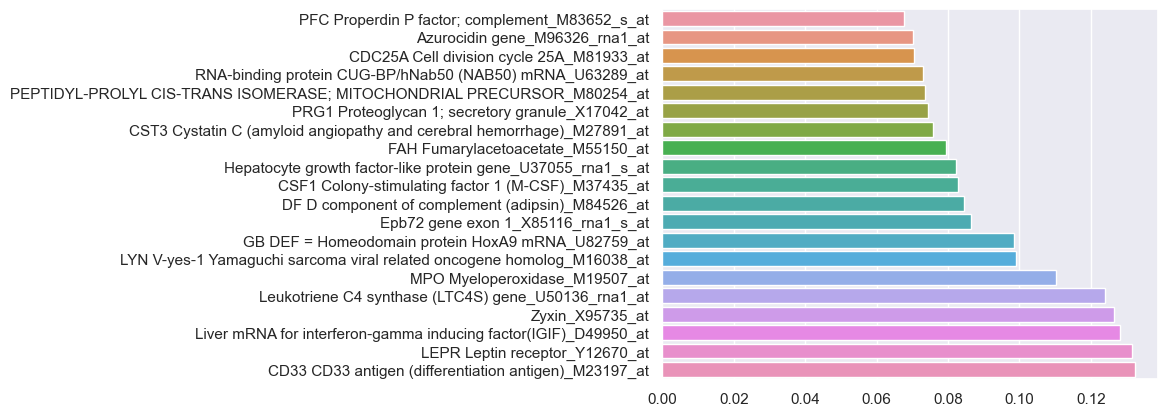

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

print("Original Shape:", train_scaled.shape)
logistic_regression = LogisticRegression(penalty="l1", solver='saga', max_iter=2000).fit(
    train_scaled, train_target)  # l1 for sparsity
log_coefficients = logistic_regression.coef_
selector_log = SelectFromModel(logistic_regression, prefit=True)
train_scaled_logreg = selector_log.transform(train_scaled)
test_scaled_logreg = selector_log.transform(test_scaled)
print("Features after selection using Logistic Regression:",
      train_scaled_logreg.shape)


log_coefficients_abs = abs(log_coefficients)
log_coefficients_abs_sort = np.sort(log_coefficients_abs).flatten()
sortedidx = log_coefficients_abs.argsort()
log_labels = train_scaled.columns.values[sortedidx].flatten()
sns.barplot(x=log_coefficients_abs_sort[-20:], y=log_labels[-20:])

### Feature Scaling using PCA


In [17]:
pca = PCA(n_components=3)
pca.fit_transform(train_scaled_logreg)
print(pca.explained_variance_ratio_)

PCA_df = pd.DataFrame(data=pca.fit_transform(train_scaled_logreg),
                      columns=['pc1', 'pc2', 'pc3'])

[0.39758334 0.08187505 0.0603069 ]


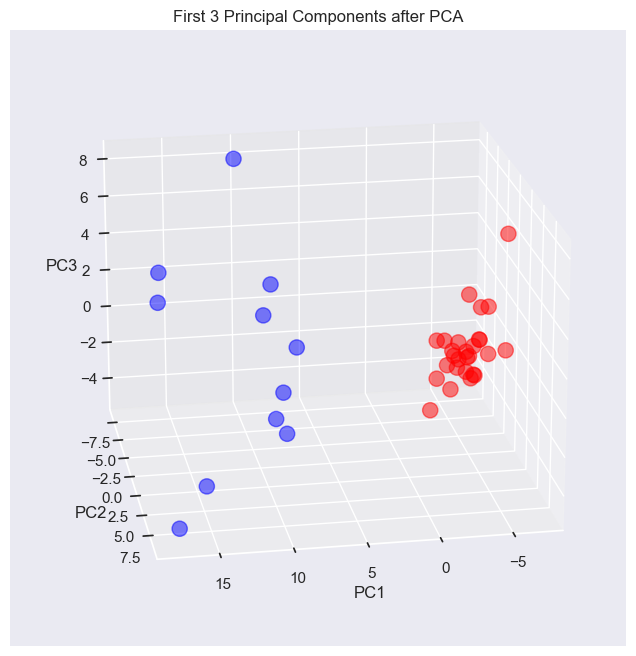

In [18]:
PCA_df = pd.concat([PCA_df, train_target], axis=1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = {'ALL': 'red', 'AML': 'blue'}
ax.scatter(PCA_df.pc1, PCA_df.pc2, PCA_df.pc3,
           c=train_target.apply(lambda x: colors[x]),
           s=120, alpha=0.5
           )
plt.title('First 3 Principal Components after PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(20, 80)
plt.tight_layout
plt.show()

# Models being tested

1. C-Support Vector Classification (SVM)

- Using Grid search for tuning hyperparameters

2. Random forest Classifier

- Using Grid search for tuning hyperparameters

3. Neural Networks

- Using only Grid search


## SVM


### Grid search for SVM


In [19]:
svc = SVC()

### Grid search parameters


In [20]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'linear', 'sigmoid'], }

grid = GridSearchCV(svc, param_grid, cv=5)

### Best parameters


In [21]:
grid.fit(train_scaled_logreg, train_target)
print(f"Best parameters for SVM are: {grid.best_params_}")

Best parameters for SVM are: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


### Selecting the best svm model


In [22]:
svc = grid.best_estimator_

### Fitting the model


In [23]:
svc.fit(train_scaled_logreg, train_target)

SVC(C=0.1, gamma=1, kernel='linear')

### Evaluation of the model


In [24]:
# predicting the values
test_pred = svc.predict(test_scaled_logreg)

# calculating the accuracy, precision, recall, f1-score, roc_auc_score
print(
    f"Accuracy of the best SVM model is: {accuracy_score(test_target, test_pred)}")
print(
    f"Precision of the best SVM model is: {precision_score(test_target, test_pred, pos_label='AML')}")
print(
    f"Recall of the best SVM model is: {recall_score(test_target, test_pred, pos_label='AML')}")
print(
    f"F1-score of the best SVM model is: {f1_score(test_target, test_pred, pos_label='AML')}")

Accuracy of the best SVM model is: 0.9705882352941176
Precision of the best SVM model is: 0.9333333333333333
Recall of the best SVM model is: 1.0
F1-score of the best SVM model is: 0.9655172413793104


TypeError: got an unexpected keyword argument 'pos_label'

### Plotting the confusion matrix


In [ ]:
# confusion matrix
cm = confusion_matrix(test_target, test_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

## Random Forest


In [ ]:
# using Random Forest and performing grid search to find the best parameters
rfc = RandomForestClassifier(random_state=0)

# defining parameter range
param_grid = {'n_estimators': [60, 70, 80, 90, 100],
              'max_features': [0.6, 0.7, 0.8, 0.9],
              'min_samples_leaf': [8, 10, 12, 14],
              'min_samples_split': [3, 5, 7]}


grid = GridSearchCV(rfc, param_grid, cv=3, scoring='accuracy')

### Best parameters


In [ ]:
grid.fit(train_scaled_logreg, train_target)
print(f"Best parameters for Random Forest are: {grid.best_params_}")

### Selecting the best random forest model


In [ ]:
rfc = grid.best_estimator_

### Fitting the model


In [ ]:
rfc.fit(train_scaled_logreg, train_target)

### Evaluation of the model


In [ ]:
# predicting the values
test_pred = rfc.predict(test_scaled_logreg)

# calculating the accuracy, precision, recall, f1-score, roc_auc_score
print(
    f"Accuracy of the best Random Forest model is: {accuracy_score(test_target, test_pred)}")
print(
    f"Precision of the best Random Forest model is: {precision_score(test_target, test_pred, average='macro')}")
print(
    f"Recall of the best Random Forest model is: {recall_score(test_target, test_pred, average='macro')}")
print(
    f"F1 Score of the best Random Forest model is: {f1_score(test_target, test_pred, average='macro')}")

### Plotting the confusion matrix


In [ ]:
# confusion matrix
cm = confusion_matrix(test_target, test_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

## Neural Network


### Grid search for MLP


In [ ]:
mlp = MLPClassifier(max_iter=1000)

### Grid Parameters


In [ ]:
param_grid = {'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
              'activation': ['tanh', 'relu', 'logistic'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant', 'adaptive']}


grid = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy')

### Best parameters


In [ ]:
grid.fit(train_scaled_logreg, train_target)
print(f"Best parameters for Neural Network are: {grid.best_params_}")

### Selecting the best neural network model


In [ ]:
mlp = grid.best_estimator_

### Fitting the model


In [ ]:
mlp.fit(train_scaled_logreg, train_target)

### Evaluating the model


In [ ]:
# predicting the values
test_pred = mlp.predict(test_scaled_logreg)

# calculating the accuracy, precision, recall, f1-score, roc_auc_score
print(
    f"Accuracy of the best Neural Network model is: {accuracy_score(test_target, test_pred)}")
print(
    f"Precision of the best Neural Network model is: {precision_score(test_target, test_pred, average='macro')}")
print(
    f"Recall of the best Neural Network model is: {recall_score(test_target, test_pred, average='macro')}")
print(
    f"F1 Score of the best Neural Network model is: {f1_score(test_target, test_pred, average='macro')}")

### Plotting the confusion matrix


In [ ]:
# confusion matrix
cm = confusion_matrix(test_target, test_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()